In [1]:
#@title Setup
from sbsim.smart_control.utils.scenario_generator import generate_scenario, get_env, print_action_spec, SimulationTracker

# Generate scenario
result = generate_scenario("scenarios/example_scenario.yaml")
print(f"Generated {result['num_rooms']} rooms with {result['num_ahus']} AHUs")

# Create environment
env = get_env(result)
print(">>>>>",env.reward_function.weights)

tracker = SimulationTracker(env, vmin=280, vmax=305)

Generated 41 rooms with 2 AHUs


2026-02-10 21:06:22.059808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-10 21:06:22.059858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-10 21:06:22.062819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-10 21:06:22.070912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-10 21:06:22.824170: W tensorflow/compiler/tf2

>>>>> {'energy_cost_weight': 0.2, 'carbon_emission_weight': 0.2, 'productivity_weight': 0.6}



Policy: all_off


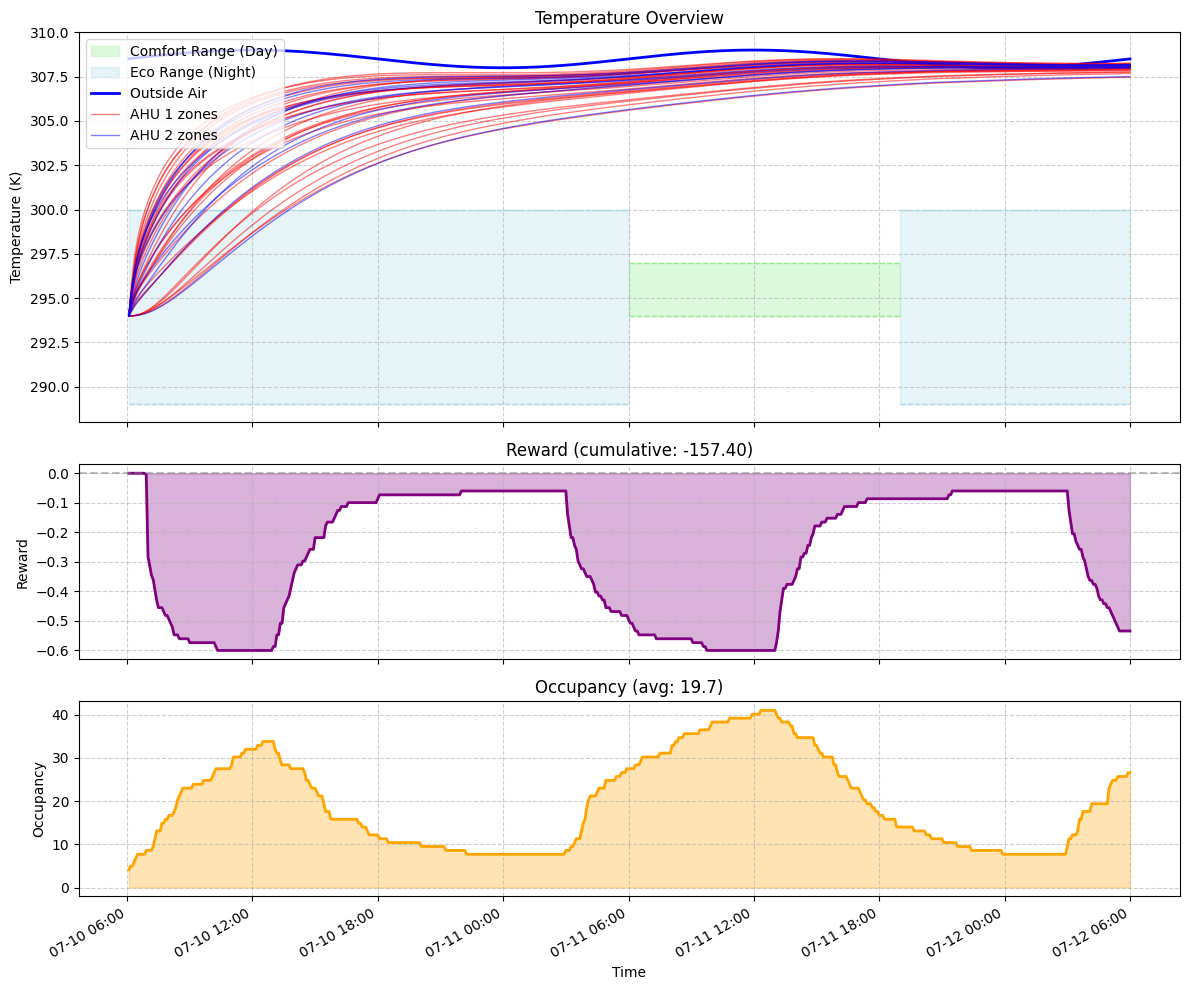

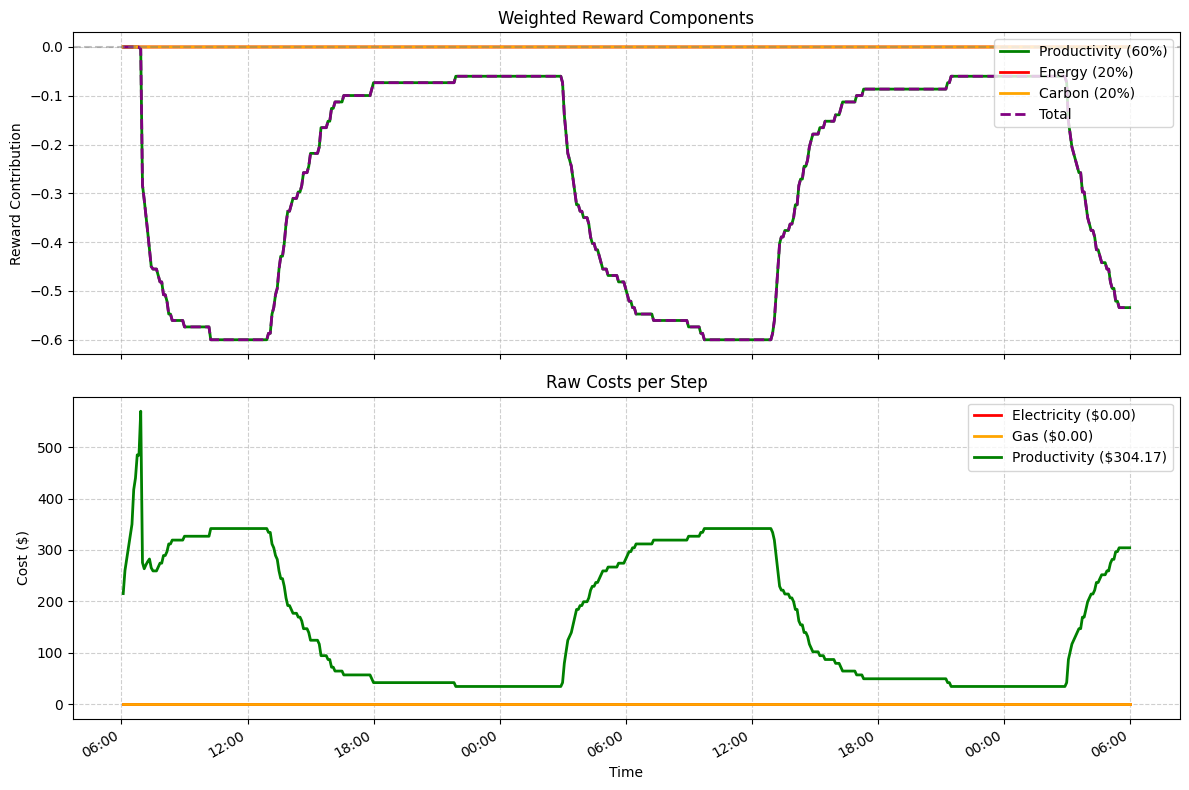


Policy: all_on


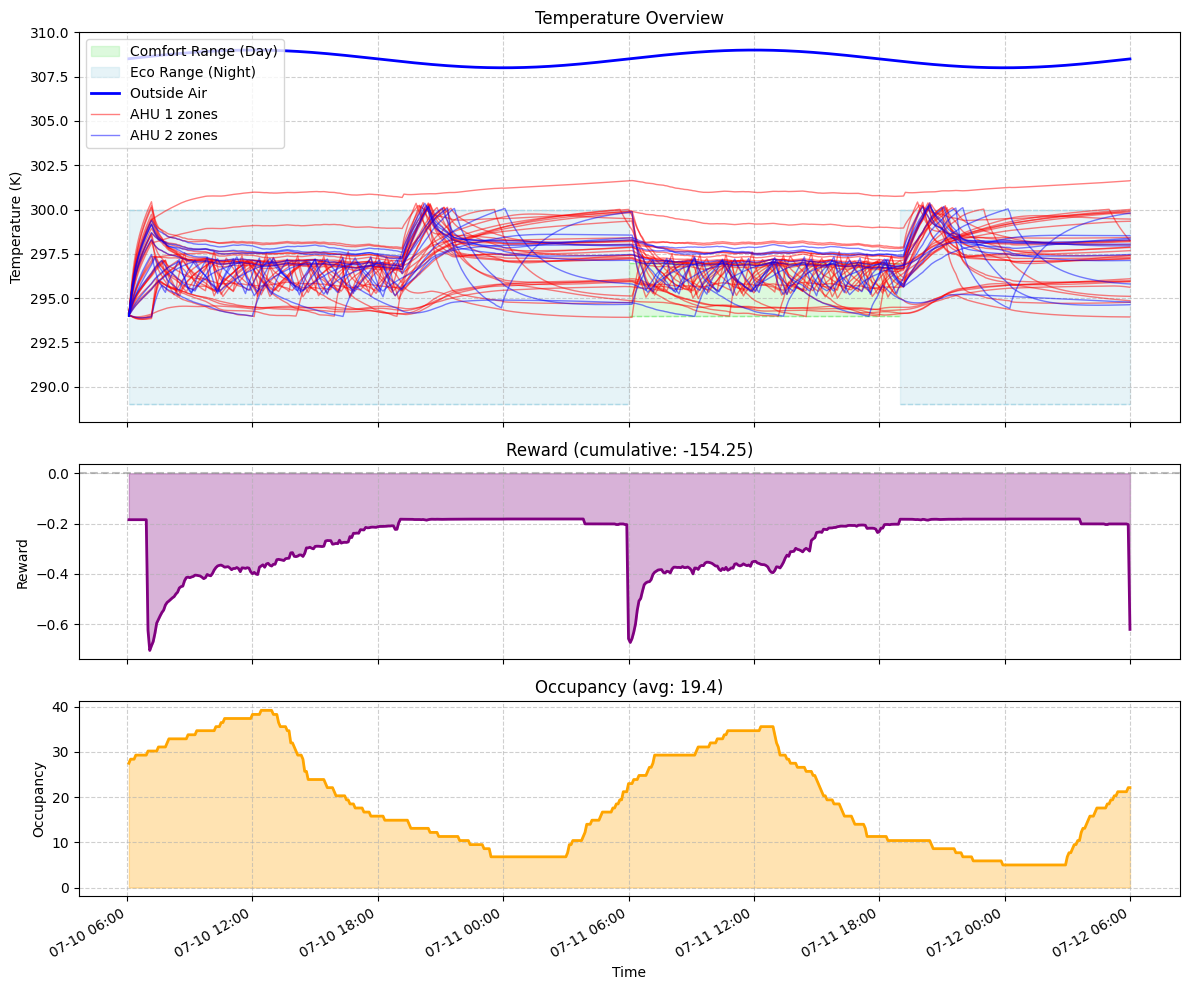

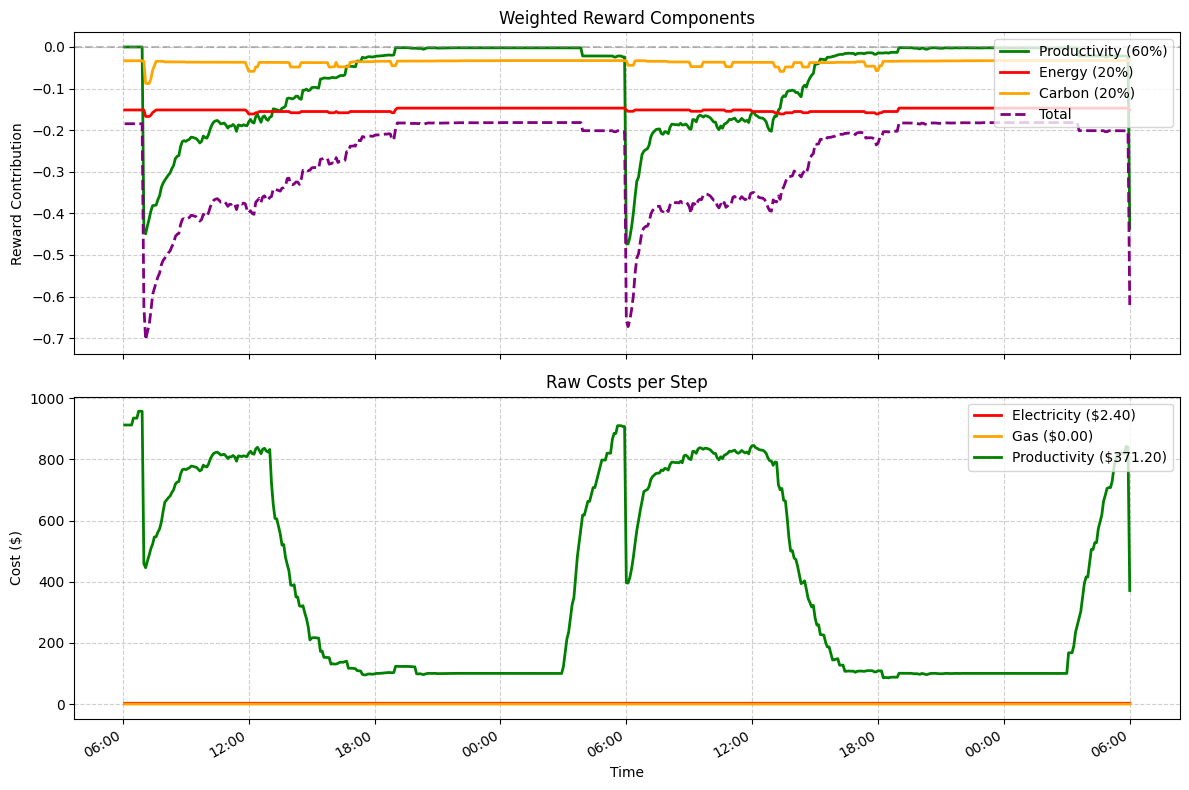


Policy: bang_bang


In [ ]:
#@title Run Baseline Policies
import numpy as np

def get_action_indices(env):
    """Get indices for each action type in continuous_action."""
    temp_indices = []
    pressure_indices = []
    water_temp_indices = []
    
    idx = 0
    for device, action_name in env._device_action_tuples:
        if 'run_command' in action_name:
            continue  # discrete
        if 'supply_air_temperature' in action_name:
            temp_indices.append(idx)
        elif 'supply_water_setpoint' in action_name:
            water_temp_indices.append(idx)
        else:  # pressure setpoints
            pressure_indices.append(idx)
        idx += 1
    
    return temp_indices, pressure_indices, water_temp_indices

def make_action(env, discrete_value: int, temp_value: float, pressure_value: float, water_value: float):
    """Create action dict with proper values per action type."""
    n_discrete = env.action_spec()['discrete_action'].shape[0]
    n_continuous = env.action_spec()['continuous_action'].shape[0]
    
    temp_idx, pressure_idx, water_idx = get_action_indices(env)
    
    continuous = [0.0] * n_continuous
    for i in temp_idx:
        continuous[i] = temp_value
    for i in pressure_idx:
        continuous[i] = pressure_value
    for i in water_idx:
        continuous[i] = water_value
    
    return {
        'discrete_action': [discrete_value] * n_discrete,
        'continuous_action': continuous,
    }

def get_avg_zone_temp(env):
    """Get average zone temperature from environment."""
    temps = [vav.zone_air_temperature for vav in env.building.simulator._hvac._vavs.values()]
    return np.mean(temps)

def get_current_setpoints(env):
    """Get current (heating, cooling) setpoints based on schedule."""
    schedule = env.building.simulator._hvac.schedule
    timestamp = env.building.current_timestamp
    return schedule.get_temperature_window(timestamp)

def run_baseline(env, tracker, policy: str, steps: int = 100):
    """Run a baseline policy."""
    tracker.reset()
    
    for _ in range(steps):
        if policy == "all_off":
            # All systems OFF, all setpoints to min
            action = make_action(env, discrete_value=0, temp_value=-1, pressure_value=-1, water_value=-1)
        
        elif policy == "all_on":
            # All systems ON at max capacity
            # AHU temp = -1 (coldest = max cooling), pressure = 1, water = 1
            action = make_action(env, discrete_value=1, temp_value=-1, pressure_value=1, water_value=1)
        
        elif policy == "bang_bang":
            zone_temp = get_avg_zone_temp(env)
            heating_setpoint, cooling_setpoint = get_current_setpoints(env)
            
            if zone_temp < heating_setpoint:
                # Too cold - turn on heating (warm supply air)
                action = make_action(env, discrete_value=1, temp_value=1, pressure_value=1, water_value=1)
            elif zone_temp > cooling_setpoint:
                # Too hot - turn on cooling (cold supply air)
                action = make_action(env, discrete_value=1, temp_value=-1, pressure_value=1, water_value=1)
            else:
                # In comfort band - turn off
                action = make_action(env, discrete_value=0, temp_value=-1, pressure_value=-1, water_value=-1)
        
        tracker.step(action)

# Compare baselines
results = {}
for policy in ["all_off", "all_on", "bang_bang"]:
    print(f"\n{'='*50}")
    print(f"Policy: {policy}")
    print('='*50)
    run_baseline(env, tracker, policy, steps=12*24*2)
    results[policy] = sum(tracker.rewards)
    tracker.plot_overview(color_by_ahu=True)  # Color zones by AHU
    tracker.plot_rewards()  # Reward component breakdown

print(f"\n{'='*50}")
print("Total Rewards:")
for name, reward in results.items():
    print(f"  {name}: {reward:.2f}")